In [1]:
import torch
import pandas as pd
import numpy as np
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Define the path where your model and tokenizer are saved in Drive
model_path = "/content/drive/My Drive/ADL Final Project/final_model"

In [5]:
# Load the tokenizer and model from Drive
tokenizer = DistilBertTokenizer.from_pretrained(model_path)
model = DistilBertForSequenceClassification.from_pretrained(model_path)
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [6]:
# Load test dataset from Drive
test_csv_path = "/content/drive/My Drive/ADL Final Project/yelp_dataset_test.csv"
test_df = pd.read_csv(test_csv_path)

# Short vs. Long Reviews

In [7]:
# Define short and long review threshold
def classify_review_length(review, threshold=100):
    return 'long' if len(review.split()) > threshold else 'short'

test_df['length_category'] = test_df['review_text'].apply(classify_review_length)

# Split
short_df = test_df[test_df['length_category'] == 'short']
long_df = test_df[test_df['length_category'] == 'long']


In [8]:
class YelpDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

API: 0201976ec5026583f1d8d0f3e0a58b42e710eea0

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: neel-1999 (neel-1999-humber-college) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin



=== Results for Short Reviews ===
Accuracy: 0.9483
Precision: 0.9481
Recall: 0.9483
F1 Score: 0.9482
Confusion Matrix:
[[4459  157   18]
 [ 187 4150  241]
 [  21  182 6174]]


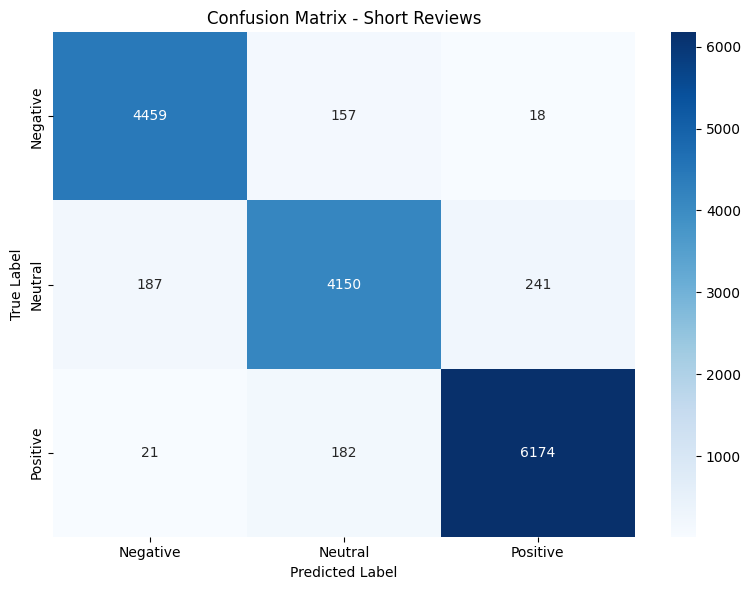


=== Results for Long Reviews ===
Accuracy: 0.9613
Precision: 0.9613
Recall: 0.9613
F1 Score: 0.9613
Confusion Matrix:
[[5217  138   11]
 [ 157 5141  124]
 [   8  119 3496]]


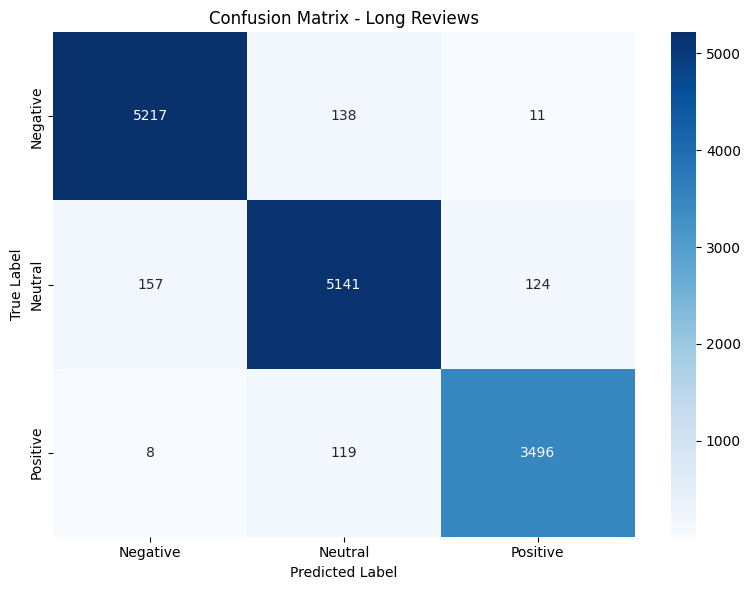

In [9]:
results = {}

def evaluate_split_with_return(df, split_name):
    texts = df['review_text'].tolist()
    labels = df['class_index'].tolist()

    encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
    dataset = YelpDataset(encodings, labels)

    trainer = Trainer(model=model)
    predictions = trainer.predict(dataset)
    preds = np.argmax(predictions.predictions, axis=1)

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted', zero_division=0)
    cm = confusion_matrix(labels, preds)

    print(f"\n=== Results for {split_name} Reviews ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)

    class_names = ['Negative', 'Neutral', 'Positive']
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {split_name} Reviews')
    plt.tight_layout()
    plt.show()

    return acc

results["Short"] = evaluate_split_with_return(short_df, "Short")
results["Long"] = evaluate_split_with_return(long_df, "Long")


<ipython-input-10-2fe62536d428>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(results.keys()), y=list(results.values()), palette='Set2')


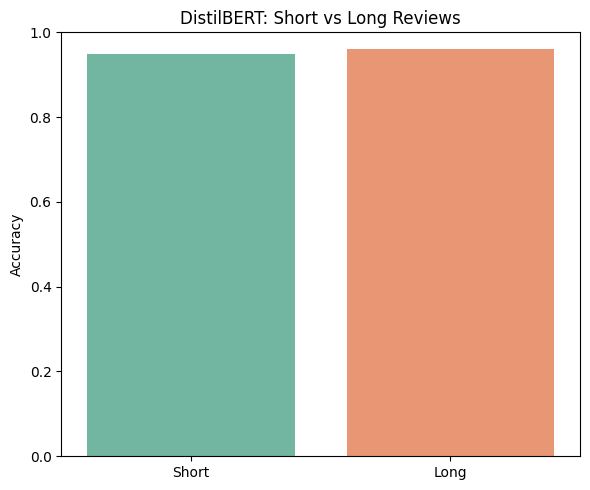

In [10]:
plt.figure(figsize=(6, 5))
sns.barplot(x=list(results.keys()), y=list(results.values()), palette='Set2')
plt.title("DistilBERT: Short vs Long Reviews")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# Vocabulary Analysis using LIME

In [11]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=64e63d384f49e1004bd8e4535e4e8736c504c3875fd05261ba97ace951834e81
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [12]:
from lime.lime_text import LimeTextExplainer
from collections import Counter, defaultdict
import random
import torch.nn.functional as F

#model needs to be on cpu for LIME
model = model.cpu()

class_names = ['negative', 'neutral', 'positive']
explainer = LimeTextExplainer(class_names=class_names)

def predict_proba_for_lime(texts):
    encodings = tokenizer(texts, truncation=True, padding=True, return_tensors="pt", max_length=512)
    input_ids = encodings['input_ids']
    attention_mask = encodings['attention_mask']

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = F.softmax(logits, dim=1).numpy()
    return probs


In [13]:
# Track the top influential words per class
top_words_per_class = defaultdict(Counter)
N_SAMPLES = 50

for class_idx, class_label in enumerate(class_names):
    class_df = test_df[test_df['class_index'] == class_idx].sample(N_SAMPLES, random_state=42)

    for text in class_df['review_text']:
        exp = explainer.explain_instance(text, predict_proba_for_lime, num_features=10, num_samples=300, labels=[class_idx])
        influential_words = [word for word, weight in exp.as_list(label=class_idx)[:3]]
        top_words_per_class[class_label].update(influential_words)
        torch.cuda.empty_cache()


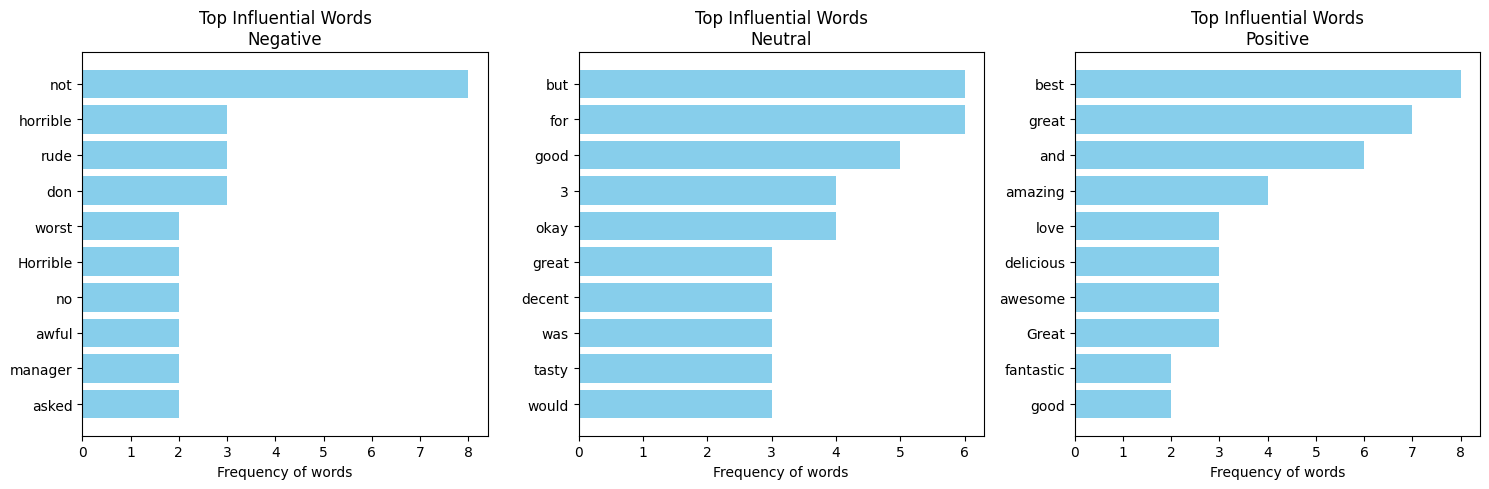

In [14]:
plt.figure(figsize=(15, 5))

for i, class_label in enumerate(class_names):
    top_words = top_words_per_class[class_label].most_common(10)
    if top_words:
        words, counts = zip(*top_words)

        plt.subplot(1, 3, i+1)
        plt.barh(words, counts, color='skyblue')
        plt.gca().invert_yaxis()
        plt.title(f"Top Influential Words\n{class_label.capitalize()}")
        plt.xlabel("Frequency of words")

plt.tight_layout()
plt.show()

# Attention Weights Evaluation

In [17]:
model = model.to(device)
model.eval()

sample_text = test_df['review_text'].iloc[0]
inputs = tokenizer(sample_text, return_tensors='pt', truncation=True, padding='max_length', max_length=512)
inputs = {key: value.to(device) for key, value in inputs.items()}

In [20]:
# Run inference with no gradient calculation
with torch.no_grad():
    outputs = model(**inputs, output_attentions=True)

# Extract attention weights from model outputs for each layer
attentions = outputs.attentions
attention_layer = attentions[0]
avg_attention = attention_layer.squeeze(0).mean(dim=0).cpu().numpy()
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'].squeeze().cpu().numpy())

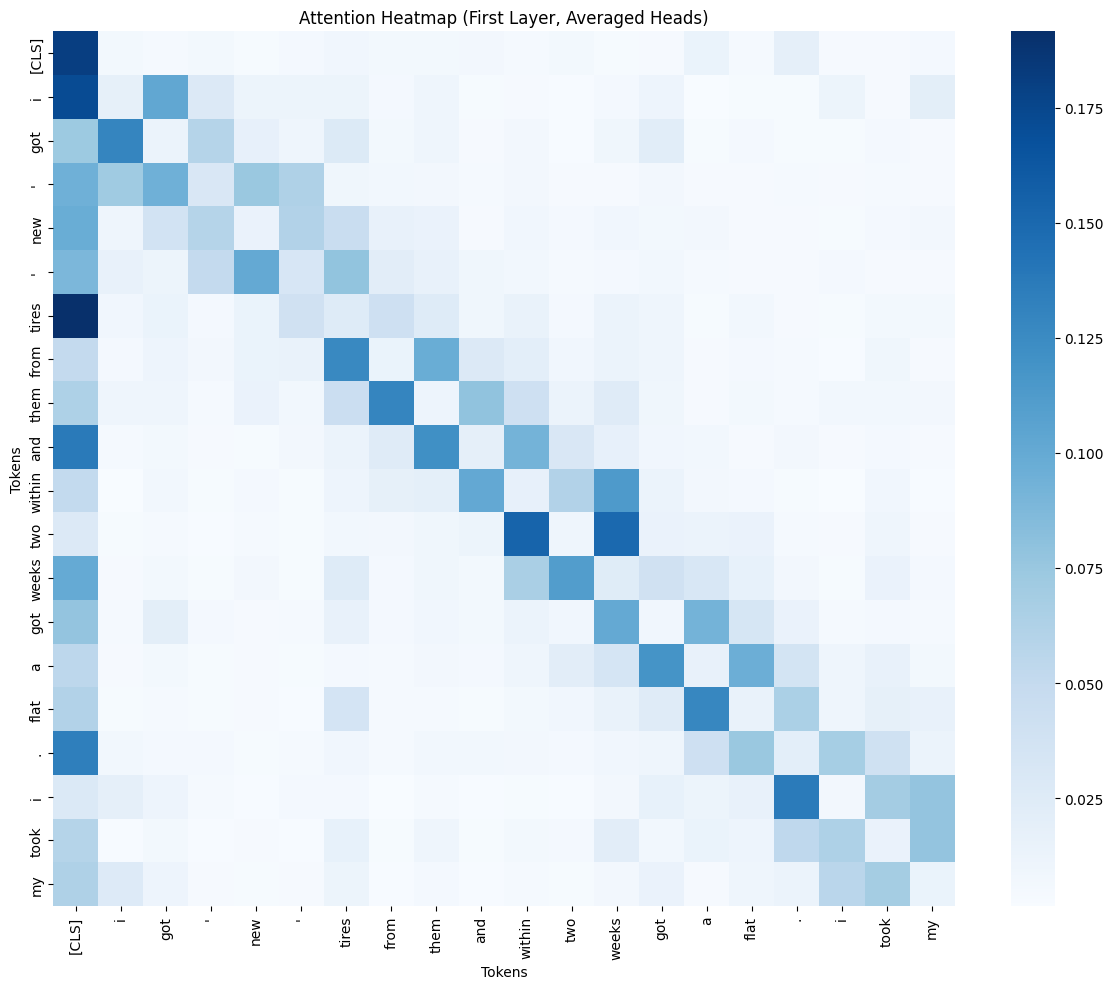

In [23]:
N = 20
avg_attention_trimmed = avg_attention[:N, :N]
tokens_trimmed = tokens[:N]

# Plot the heatmap
plt.figure(figsize = (12, 10))
sns.heatmap(avg_attention_trimmed, xticklabels = tokens_trimmed, yticklabels = tokens_trimmed, cmap = 'Blues')
plt.title("Attention Heatmap (First Layer, Averaged Heads)")
plt.xlabel("Tokens")
plt.ylabel("Tokens")
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()